# Writing to a File

## Overview

### Questions

* How can I write thermodynamic and other quantities to a file?
* How can I access that data?

### Objectives

* Show how to add all **thermodynamic properties** to a Logger.
* Demonstrate **GSD** as a log writer.
* Demonstrate **Table** as a log writer.
* Explain how to read logged quantities from files.
* Describe how **namespaces** appear in the names of the logged quantities.

## Boilerplate code

In [1]:
import hoomd
import gsd.hoomd
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from a previous tutorial. 
See [*Introducing Molecular Dyamics*](../01-Introducing-Molecular-Dynamics/00-index.ipynb) for a complete description of this code.

In [2]:
gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=gpu)
sim.create_state_from_gsd(filename='../01-Introducing-Molecular-Dynamics/random.gsd')

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.run(0)

## Logging thermodynamic quantities

The **ThermodynamicQuantities** class computes a variety of **thermodynamic properties** in MD simulations.
These are all loggable.

In [3]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)
thermodynamic_properties.loggables

{'state': 'state',
 'kinetic_temperature': 'scalar',
 'pressure': 'scalar',
 'pressure_tensor': 'sequence',
 'kinetic_energy': 'scalar',
 'translational_kinetic_energy': 'scalar',
 'rotational_kinetic_energy': 'scalar',
 'potential_energy': 'scalar',
 'degrees_of_freedom': 'scalar',
 'translational_degrees_of_freedom': 'scalar',
 'rotational_degrees_of_freedom': 'scalar',
 'num_particles': 'scalar'}

Add all of these quantities to the logger.

In [4]:
logger = hoomd.logging.Logger()
logger.add(thermodynamic_properties)

[('md', 'compute', 'ThermodynamicQuantities', 'state'),
 ('md', 'compute', 'ThermodynamicQuantities', 'kinetic_temperature'),
 ('md', 'compute', 'ThermodynamicQuantities', 'pressure'),
 ('md', 'compute', 'ThermodynamicQuantities', 'pressure_tensor'),
 ('md', 'compute', 'ThermodynamicQuantities', 'kinetic_energy'),
 ('md', 'compute', 'ThermodynamicQuantities', 'translational_kinetic_energy'),
 ('md', 'compute', 'ThermodynamicQuantities', 'rotational_kinetic_energy'),
 ('md', 'compute', 'ThermodynamicQuantities', 'potential_energy'),
 ('md', 'compute', 'ThermodynamicQuantities', 'degrees_of_freedom'),
 ('md',
  'compute',
  'ThermodynamicQuantities',
  'translational_degrees_of_freedom'),
 ('md', 'compute', 'ThermodynamicQuantities', 'rotational_degrees_of_freedom'),
 ('md', 'compute', 'ThermodynamicQuantities', 'num_particles')]

You can also log quantities from other objects.
Add all the quantities that **Simulation** provides.

In [5]:
logger.add(sim)

[('Simulation', 'timestep'),
 ('Simulation', 'tps'),
 ('Simulation', 'walltime'),
 ('Simulation', 'final_timestep')]

**Table** only supports `scalar` and `string` quantities, so you need a **Logger** configured accordingly:

In [6]:
logger_txt = hoomd.logging.Logger(flags=['scalar', 'string'])
logger_txt.add(thermodynamic_properties)
logger_txt.add(sim)

[('Simulation', 'timestep'),
 ('Simulation', 'tps'),
 ('Simulation', 'walltime'),
 ('Simulation', 'final_timestep')]

## Writing log quantities to a text file with Table

Open the file and write to it with **Table**:

In [7]:
file = open('log.txt', 'w')
table = hoomd.write.Table(output=file,
                          trigger=hoomd.trigger.Periodic(period=1000),
                          logger=logger_txt)
sim.operations.writers.append(table)

## Writing log quantities to a GSD file

In addition to the trajectory of the simulation state, GSD files also store array data provided by an associated **Logger**.
Use the `Null` filter to select no particles so that you can log thermodynamic properties at a high rate and keep the file size small.


In [8]:
gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='wb',
                             filter=hoomd.filter.Null())
sim.operations.writers.append(gsd_writer)

Assign the logger to include the logged quanties in the GSD file:

In [9]:
gsd_writer.log = logger

## Run the simulation

The writers trigger and write to the log file when the simulation runs:

In [10]:
sim.run(200000)

## Reading logged data from a text file

You can read text files with a variety of tools, such as `tail`, `awk`, and `pandas` (use `read_csv(file, sep='\s+'`).

## Reading logged data from a GSD file

You need to close the **GSD** file that `gsd_writer` has open before you can read it.
The following code block deletes the simulation and operations manually so that it is safe to open the file for reading later in the notebook.

In typical workflows, you will run simulations and analysis scripts separately and this will happen automatically.

In [11]:
del sim, gsd_writer, table, logger, integrator, nvt, lj, cell, gpu

Use the `gsd` package to open the file:

In [12]:
traj = gsd.hoomd.open('trajectory.gsd', 'rb')

Each frame in the trajectory has a `log` dictionary that maps quantity names to values.
Inspect this dictionary in the first frame:

In [13]:
traj[0].log

{'md/compute/ThermodynamicQuantities/kinetic_temperature': array([1.53168693]),
 'md/compute/ThermodynamicQuantities/pressure': array([2.49809301]),
 'md/compute/ThermodynamicQuantities/pressure_tensor': array([ 2.41877849,  0.1068534 , -0.11846785,  2.76484544, -0.14534146,
         2.31065509]),
 'md/compute/ThermodynamicQuantities/kinetic_energy': array([1146.46766633]),
 'md/compute/ThermodynamicQuantities/translational_kinetic_energy': array([1146.46766633]),
 'md/compute/ThermodynamicQuantities/rotational_kinetic_energy': array([0.]),
 'md/compute/ThermodynamicQuantities/potential_energy': array([-2193.30514937]),
 'md/compute/ThermodynamicQuantities/degrees_of_freedom': array([1497]),
 'md/compute/ThermodynamicQuantities/translational_degrees_of_freedom': array([1497]),
 'md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom': array([0]),
 'md/compute/ThermodynamicQuantities/num_particles': array([500]),
 'Simulation/timestep': array([31000]),
 'Simulation/tps': array

The dictionary keys are verbose names that include the **namespace** of the class which computed the quantity, where `.` has been replaced with `/`.
For example, access the potential energy computed by **ThermodynamicQuantities** with the key `md/compute/ThermodynamicQuantities/potential_energy`.

In [14]:
traj[0].log['md/compute/ThermodynamicQuantities/potential_energy']

array([-2193.30514937])

**GSD** stores all quantities in arrays.
It stores scalar quantities such as the system potential energy in length 1 arrays (above) while it stores vector and other array quantities as appropriately sized arrays:

In [15]:
traj[0].log['md/compute/ThermodynamicQuantities/pressure_tensor']

array([ 2.41877849,  0.1068534 , -0.11846785,  2.76484544, -0.14534146,
        2.31065509])

**GSD** provides logged quantities individually at each frame in the file.
You can convert this to time-series data with a loop and then plot or analyze it:

In [16]:
timestep = []
walltime = []
potential_energy = []

for frame in traj:
    timestep.append(frame.configuration.step)
    walltime.append(frame.log['Simulation/walltime'][0])
    potential_energy.append(frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])

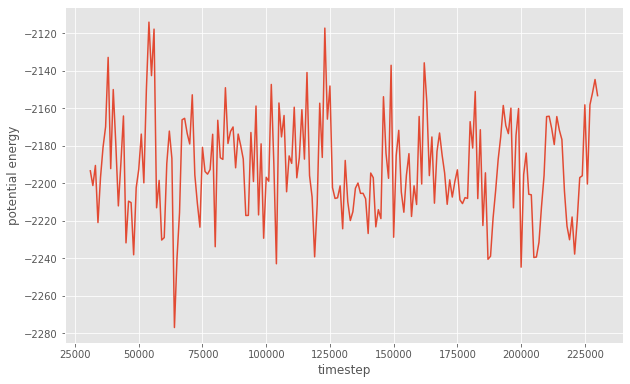

In [17]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(timestep, potential_energy)
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy')
fig

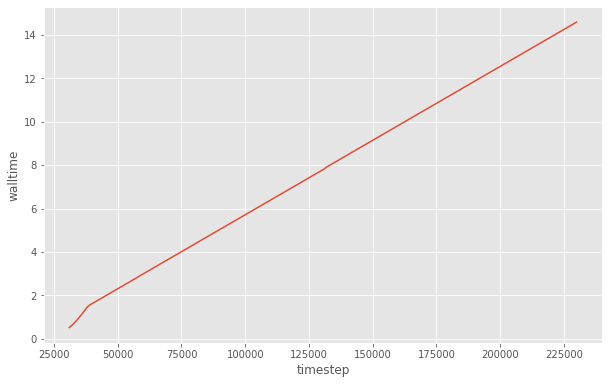

In [18]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(timestep, walltime)
ax.set_xlabel('timestep')
ax.set_ylabel('walltime')
fig

In this section, you have logged quantities to a file during a simulation run and analyzed that data as a time series.
The next section of this tutorial will show you how to save per-particle quantities associated with specific system configurations.

[Previous section](01-Displaying-Status-Information.ipynb) / [Next section](03-Saving-Array-Quantities.ipynb)